In [1]:
!pip install gensim


In [2]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences, to_categorical
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Lambda
from tensorflow.keras.models import Model
from gensim.models import KeyedVectors
import tensorflow as tf

In [3]:
df=pd.read_csv('train.csv',encoding="latin1")
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [5]:
df.isnull().sum()

,0
textID,0
text,1
selected_text,1
sentiment,0
Time of Tweet,0
Age of User,0
Country,0
Population -2020,0
Land Area (Km²),0
Density (P/Km²),0


In [6]:
df=df.dropna(subset='text')

In [7]:
df.duplicated().sum()

0

In [8]:
df['sentiment'].value_counts()

,count
sentiment,
neutral,11117
positive,8582
negative,7781


In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = nltk.word_tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(clean_preprocess)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
df['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [11]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['sentiment'])

In [12]:
import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)


In [13]:
print(le.classes_)

['negative' 'neutral' 'positive']


In [14]:
df['label'].unique()

array([1, 0, 2])

In [15]:
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)


In [16]:
train_texts = df['clean_text'].tolist()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

sequences = tokenizer.texts_to_sequences(train_texts)
max_len = 50  # fixed sequence length
X_pad = pad_sequences(sequences, maxlen=max_len)


In [17]:
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [18]:
import gensim.downloader as api
from gensim.models import KeyedVectors

# Step 1: download path only
path = api.load("word2vec-google-news-300", return_path=True)

# Step 2: load with limit
model = KeyedVectors.load_word2vec_format(path, binary=True, limit=200000)

print(len(model.key_to_index))  # should be 200,000

[==================================================] 100.0% 1662.8/1662.8MB downloaded
200000


In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.score_dense = Dense(1, activation='tanh')

    def call(self, inputs):
        # inputs: [batch, timesteps, features]
        score = self.score_dense(inputs)  # [batch, timesteps, 1]
        attention_weights = tf.nn.softmax(score, axis=1)  # normalize across timesteps
        context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)  # [batch, features]
        return context_vector


In [20]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.models import Model
MAX_LEN=50
inputs = Input(shape=(MAX_LEN,))
vocab_size = len(tokenizer.word_index) + 1   # or your vocab size
embedding_dim = 128                          # common choice

inputs = Input(shape=(MAX_LEN,))
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    input_length=MAX_LEN
)(inputs)


# Bi-LSTM
lstm_out = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))(embedding_layer)

# Attention (custom layer)
context_vector = AttentionLayer()(lstm_out)

dense = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(context_vector)
dropout = Dropout(0.5)(dense)
outputs = Dense(3, activation='softmax')(dropout)

# Model
rnn_model = Model(inputs=inputs, outputs=outputs)
rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [21]:
y_cat = to_categorical(df['label'], num_classes=3)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Save best model as .keras
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(df['label']),
    y=df['label']
)
cw_dict = dict(enumerate(class_weights))

history = rnn_model.fit(
    X_pad, y_cat,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, checkpoint],
    class_weight=cw_dict
)

Epoch 1/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.3463 - loss: 1.2362
Epoch 1: val_loss improved from inf to 1.01091, saving model to best_model.keras
687/687 ━━━━━━━━━━━━━━━━━━━━ 198s 267ms/step - accuracy: 0.3464 - loss: 1.2361 - val_accuracy: 0.4549 - val_loss: 1.0109
Epoch 2/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.4279 - loss: 0.9968
Epoch 2: val_loss improved from 1.01091 to 0.91017, saving model to best_model.keras
687/687 ━━━━━━━━━━━━━━━━━━━━ 143s 191ms/step - accuracy: 0.4279 - loss: 0.9967 - val_accuracy: 0.5271 - val_loss: 0.9102
Epoch 3/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.5312 - loss: 0.8980
Epoch 3: val_loss improved from 0.91017 to 0.85861, saving model to best_model.keras
687/687 ━━━━━━━━━━━━━━━━━━━━ 142s 192ms/step - accuracy: 0.5312 - loss: 0.8980 - val_accuracy: 0.6141 - val_loss: 0.8586
Epoch 4/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5629 - loss: 0.8354
Epoch 4: val_loss improved from 0.

In [23]:
loss, accuracy = rnn_model.evaluate(X_pad, y_cat)
print(f"Final Accuracy: {accuracy*100:.2f}%")

859/859 ━━━━━━━━━━━━━━━━━━━━ 52s 61ms/step - accuracy: 0.8667 - loss: 0.5497
Final Accuracy: 83.09%


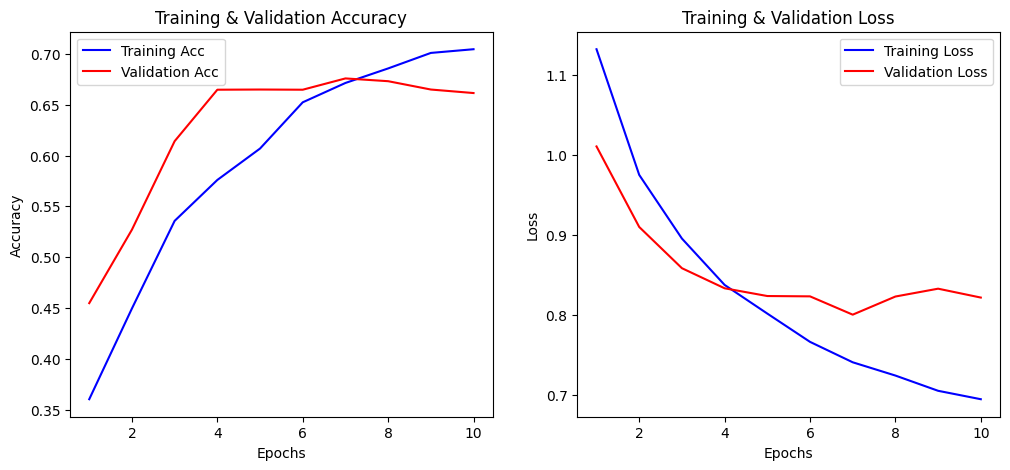

In [24]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label='Training Acc')
plt.plot(epochs, val_acc, 'r', label='Validation Acc')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [27]:
rnn_model.save("rnnmodel.h5")

In [28]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Some test cases
sample_texts = ["good", "bad", "okay", "I love this!", "This is terrible.", "meh"]

# Convert to sequences
seqs = tokenizer.texts_to_sequences(sample_texts)
padded = pad_sequences(seqs, maxlen=50)

# Get predictions
probs = rnn_model.predict(padded)
pred_classes = np.argmax(probs, axis=1)
decoded = le.inverse_transform(pred_classes)

# Print results
for text, prob, cls, dec in zip(sample_texts, probs, pred_classes, decoded):
    print(f"Text: {text}")
    print(f"Raw probs: {prob}")
    print(f"Predicted class index: {cls}")
    print(f"Decoded label: {dec}")
    print("-" * 40)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Text: good
Raw probs: [0.06223154 0.3556733  0.58209515]
Predicted class index: 2
Decoded label: positive
----------------------------------------
Text: bad
Raw probs: [0.71107197 0.2512366  0.03769149]
Predicted class index: 0
Decoded label: negative
----------------------------------------
Text: okay
Raw probs: [0.16175663 0.4717007  0.36654267]
Predicted class index: 1
Decoded label: neutral
----------------------------------------
Text: I love this!
Raw probs: [0.00145821 0.06188079 0.93666095]
Predicted class index: 2
Decoded label: positive
----------------------------------------
Text: This is terrible.
Raw probs: [0.24224687 0.49701044 0.2607427 ]
Predicted class index: 1
Decoded label: neutral
----------------------------------------
Text: meh
Raw probs: [0.29247817 0.49301204 0.2145097 ]
Predicted class index: 1
Decoded label: neutral
----------------------------------------
